In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Load in Dataset

In [2]:
file_path = './world-data-2023.csv'
data = pd.read_csv(file_path)

In [3]:
# Display basic information about the dataset
data_info = data.info()
data_description = data.describe(include='all')
data_head = data.head()

data_info, data_description, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                            195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                       

(None,
             Country Density\n(P/Km2) Abbreviation Agricultural Land( %)  \
 count           195              195          188                   188   
 unique          195              137          188                   168   
 top     Afghanistan               25           AF                17.40%   
 freq              1                7            1                     3   
 mean            NaN              NaN          NaN                   NaN   
 std             NaN              NaN          NaN                   NaN   
 min             NaN              NaN          NaN                   NaN   
 25%             NaN              NaN          NaN                   NaN   
 50%             NaN              NaN          NaN                   NaN   
 75%             NaN              NaN          NaN                   NaN   
 max             NaN              NaN          NaN                   NaN   
 
        Land Area(Km2) Armed Forces size  Birth Rate  Calling Code  \
 count   

Remove Cols


In [4]:
# Removing specified columns
columns_to_remove = ["Currency-Code", "Abbreviation", "Calling Code", "Capital/Major City", "Currency-Code","Official language", "Largest city"]

data_cleaned = data.drop(columns=columns_to_remove)

# Verifying the removal
remaining_columns = data_cleaned.columns

remaining_columns
print(data_cleaned.dtypes)
print(data_cleaned.head())

Country                                       object
Density\n(P/Km2)                              object
Agricultural Land( %)                         object
Land Area(Km2)                                object
Armed Forces size                             object
Birth Rate                                   float64
Co2-Emissions                                 object
CPI                                           object
CPI Change (%)                                object
Fertility Rate                               float64
Forested Area (%)                             object
Gasoline Price                                object
GDP                                           object
Gross primary education enrollment (%)        object
Gross tertiary education enrollment (%)       object
Infant mortality                             float64
Life expectancy                              float64
Maternal mortality ratio                     float64
Minimum wage                                  

In [5]:
# Identify the columns to convert (excluding 'Country')
cols_to_convert = data_cleaned.columns.drop('Country')

# Convert appropriate object columns to numeric types
for col in cols_to_convert:
    if data_cleaned[col].dtype == 'object':
        data_cleaned[col] = pd.to_numeric(data_cleaned[col].str.replace(',', '').str.replace('%', '').str.replace('$', ''), errors='coerce')

# Verifying the conversion
data_types_after_conversion = data_cleaned.dtypes

# Fill numeric columns with mean
numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())

# Verifying if there are any remaining missing values
remaining_missing_values = data_cleaned.isnull().sum()

# Display columns with remaining missing values, if any
print(":",remaining_missing_values[remaining_missing_values > 0])
print(data_types_after_conversion)

: Series([], dtype: int64)
Country                                       object
Density\n(P/Km2)                               int64
Agricultural Land( %)                        float64
Land Area(Km2)                               float64
Armed Forces size                            float64
Birth Rate                                   float64
Co2-Emissions                                float64
CPI                                          float64
CPI Change (%)                               float64
Fertility Rate                               float64
Forested Area (%)                            float64
Gasoline Price                               float64
GDP                                          float64
Gross primary education enrollment (%)       float64
Gross tertiary education enrollment (%)      float64
Infant mortality                             float64
Life expectancy                              float64
Maternal mortality ratio                     float64
Minimum wage       

VIF Data:
                                      Feature        VIF
0                                       const   0.000000
1                            Density\n(P/Km2)   1.537655
2                       Agricultural Land( %)   1.665122
3                              Land Area(Km2)   2.153718
4                           Armed Forces size   5.841643
5                                  Birth Rate  54.924825
6                               Co2-Emissions  27.687688
7                                         CPI   6.190393
8                              CPI Change (%)   5.764238
9                              Fertility Rate  44.264778
10                          Forested Area (%)   1.675601
11                             Gasoline Price   1.832367
12                                        GDP   9.940553
13     Gross primary education enrollment (%)   1.361812
14    Gross tertiary education enrollment (%)   3.149511
15                           Infant mortality  11.228636
16                   

c:\Users\xamir\Documents\job_search_2023\bespoke_cvs\weavuate\globe_search_vector\globe_own\globeenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


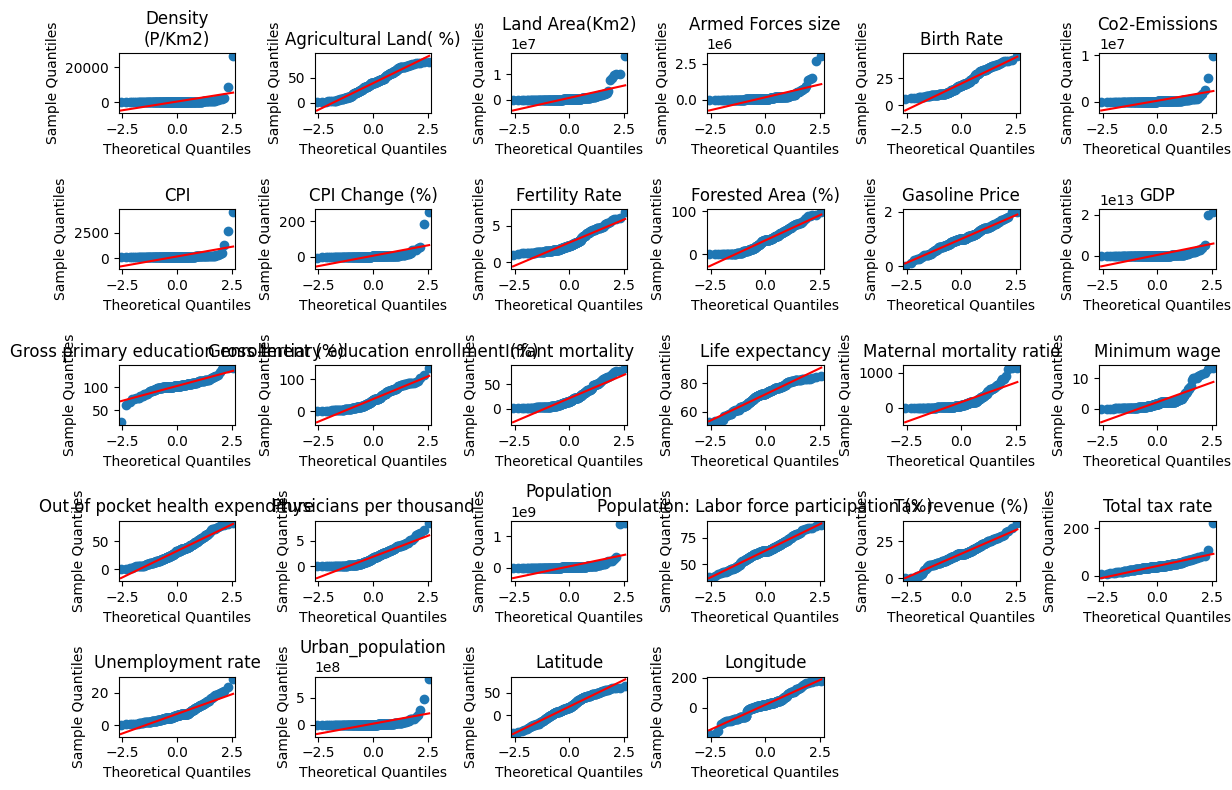

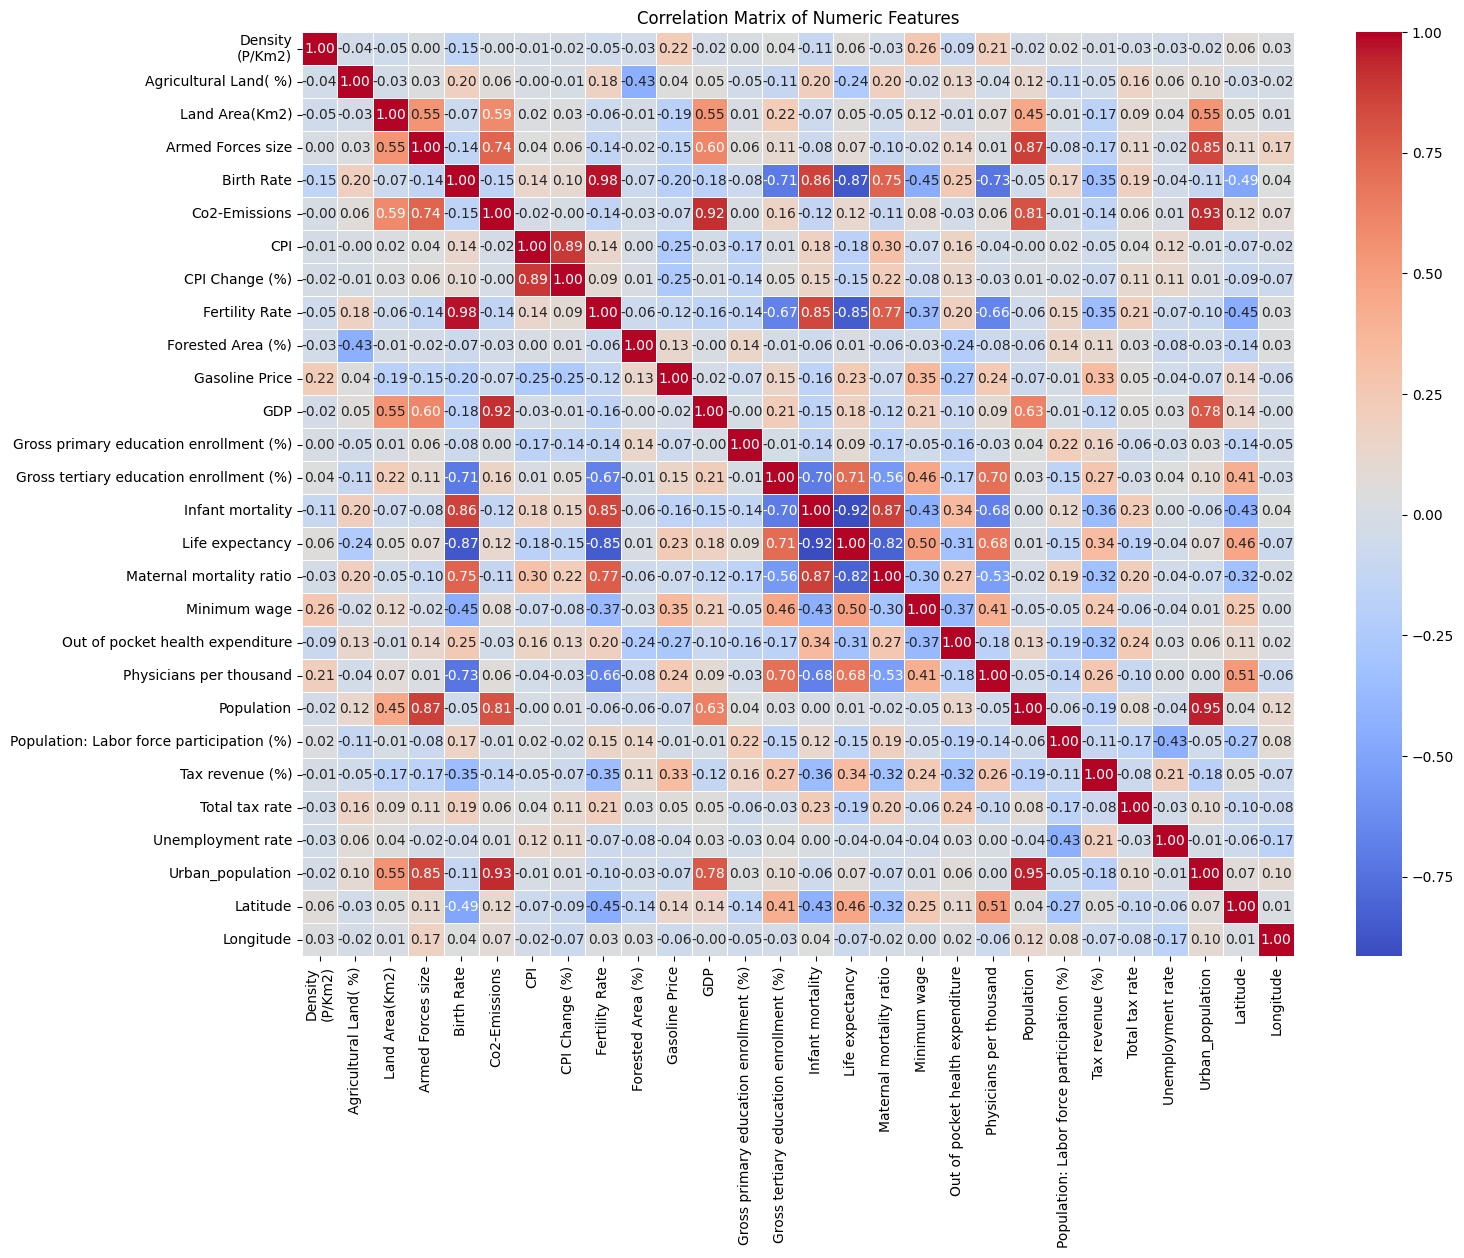

In [6]:


# Checking for multicollinearity using the Variance Inflation Factor (VIF)
# Calculate VIF for each numerical feature
X = data_cleaned[numeric_cols]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

# Checking for heteroscedasticity using Breusch-Pagan test
model = sm.OLS(data_cleaned['GDP'], sm.add_constant(data_cleaned.drop(columns=['GDP', 'Country'])))
fit = model.fit()
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(fit.resid, fit.model.exog)

print("Breusch-Pagan test p-value:", pval)
print("Breusch-Pagan test F-statistic p-value:", f_pval)

# Creating Q-Q plots for the numerical columns
fig = plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, start=1):
    ax = fig.add_subplot(5, 6, i)
    sm.qqplot(data_cleaned[col], line ='s', ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = data_cleaned[numeric_cols].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

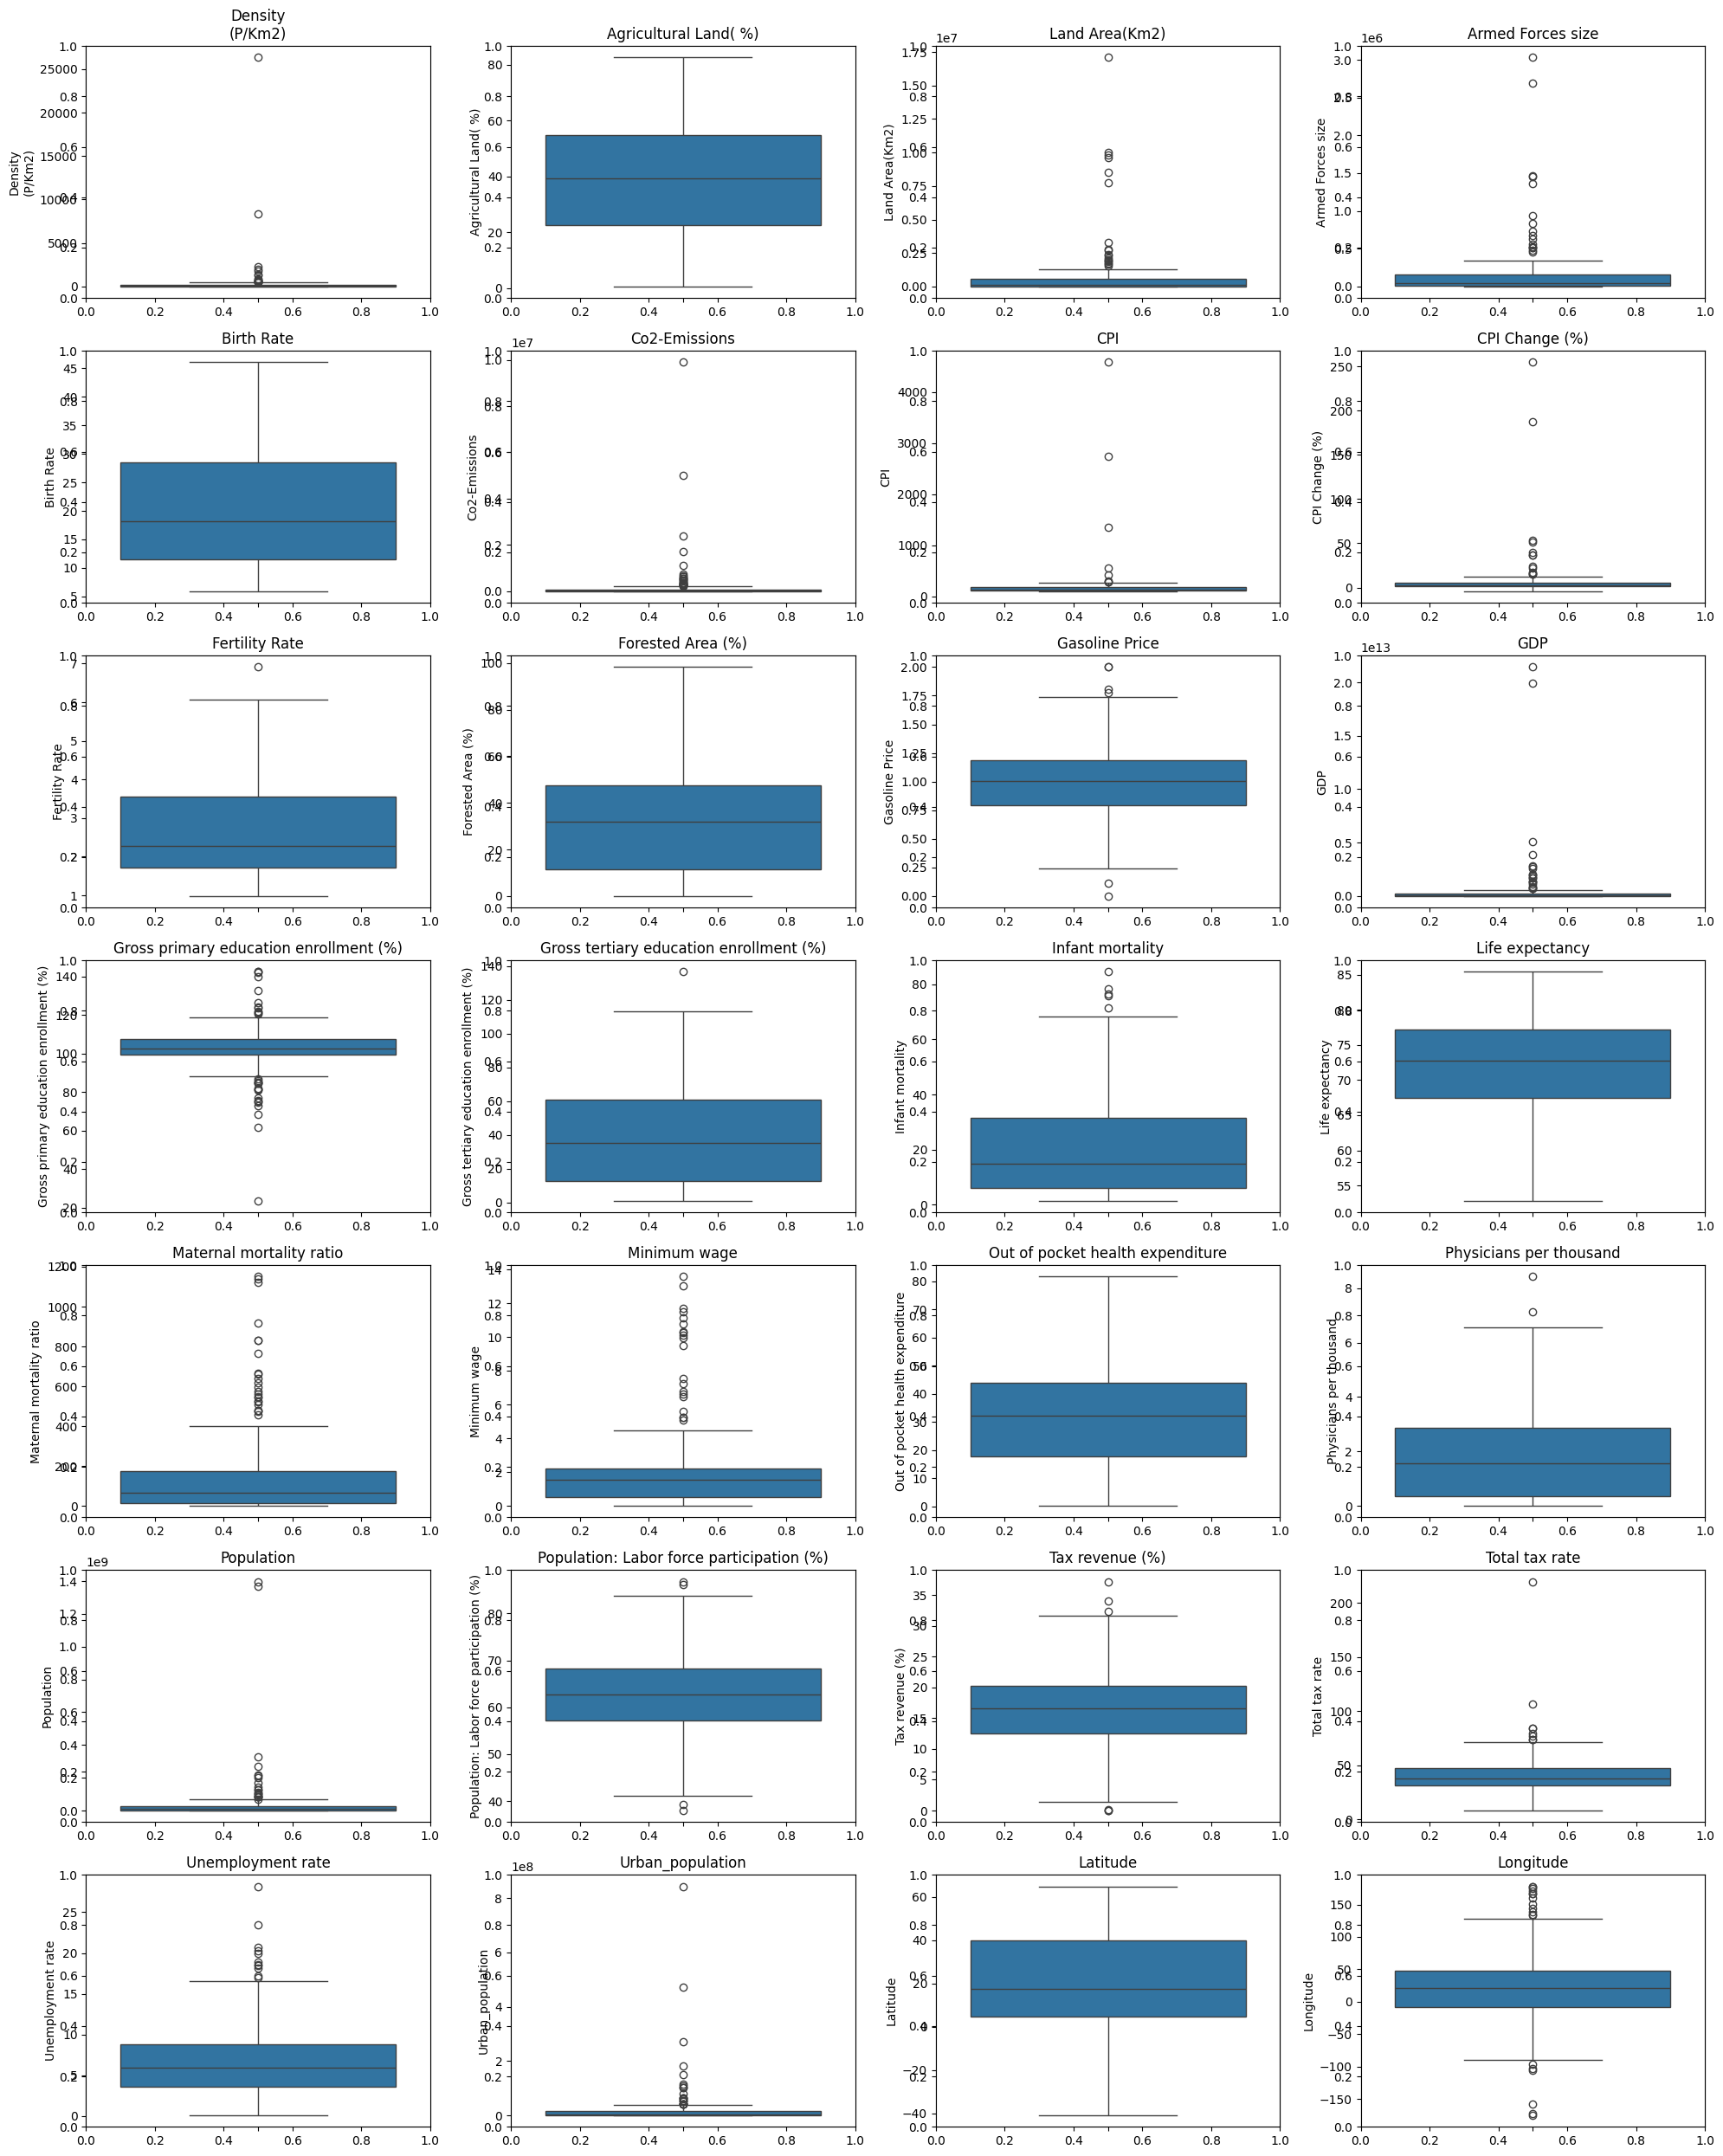

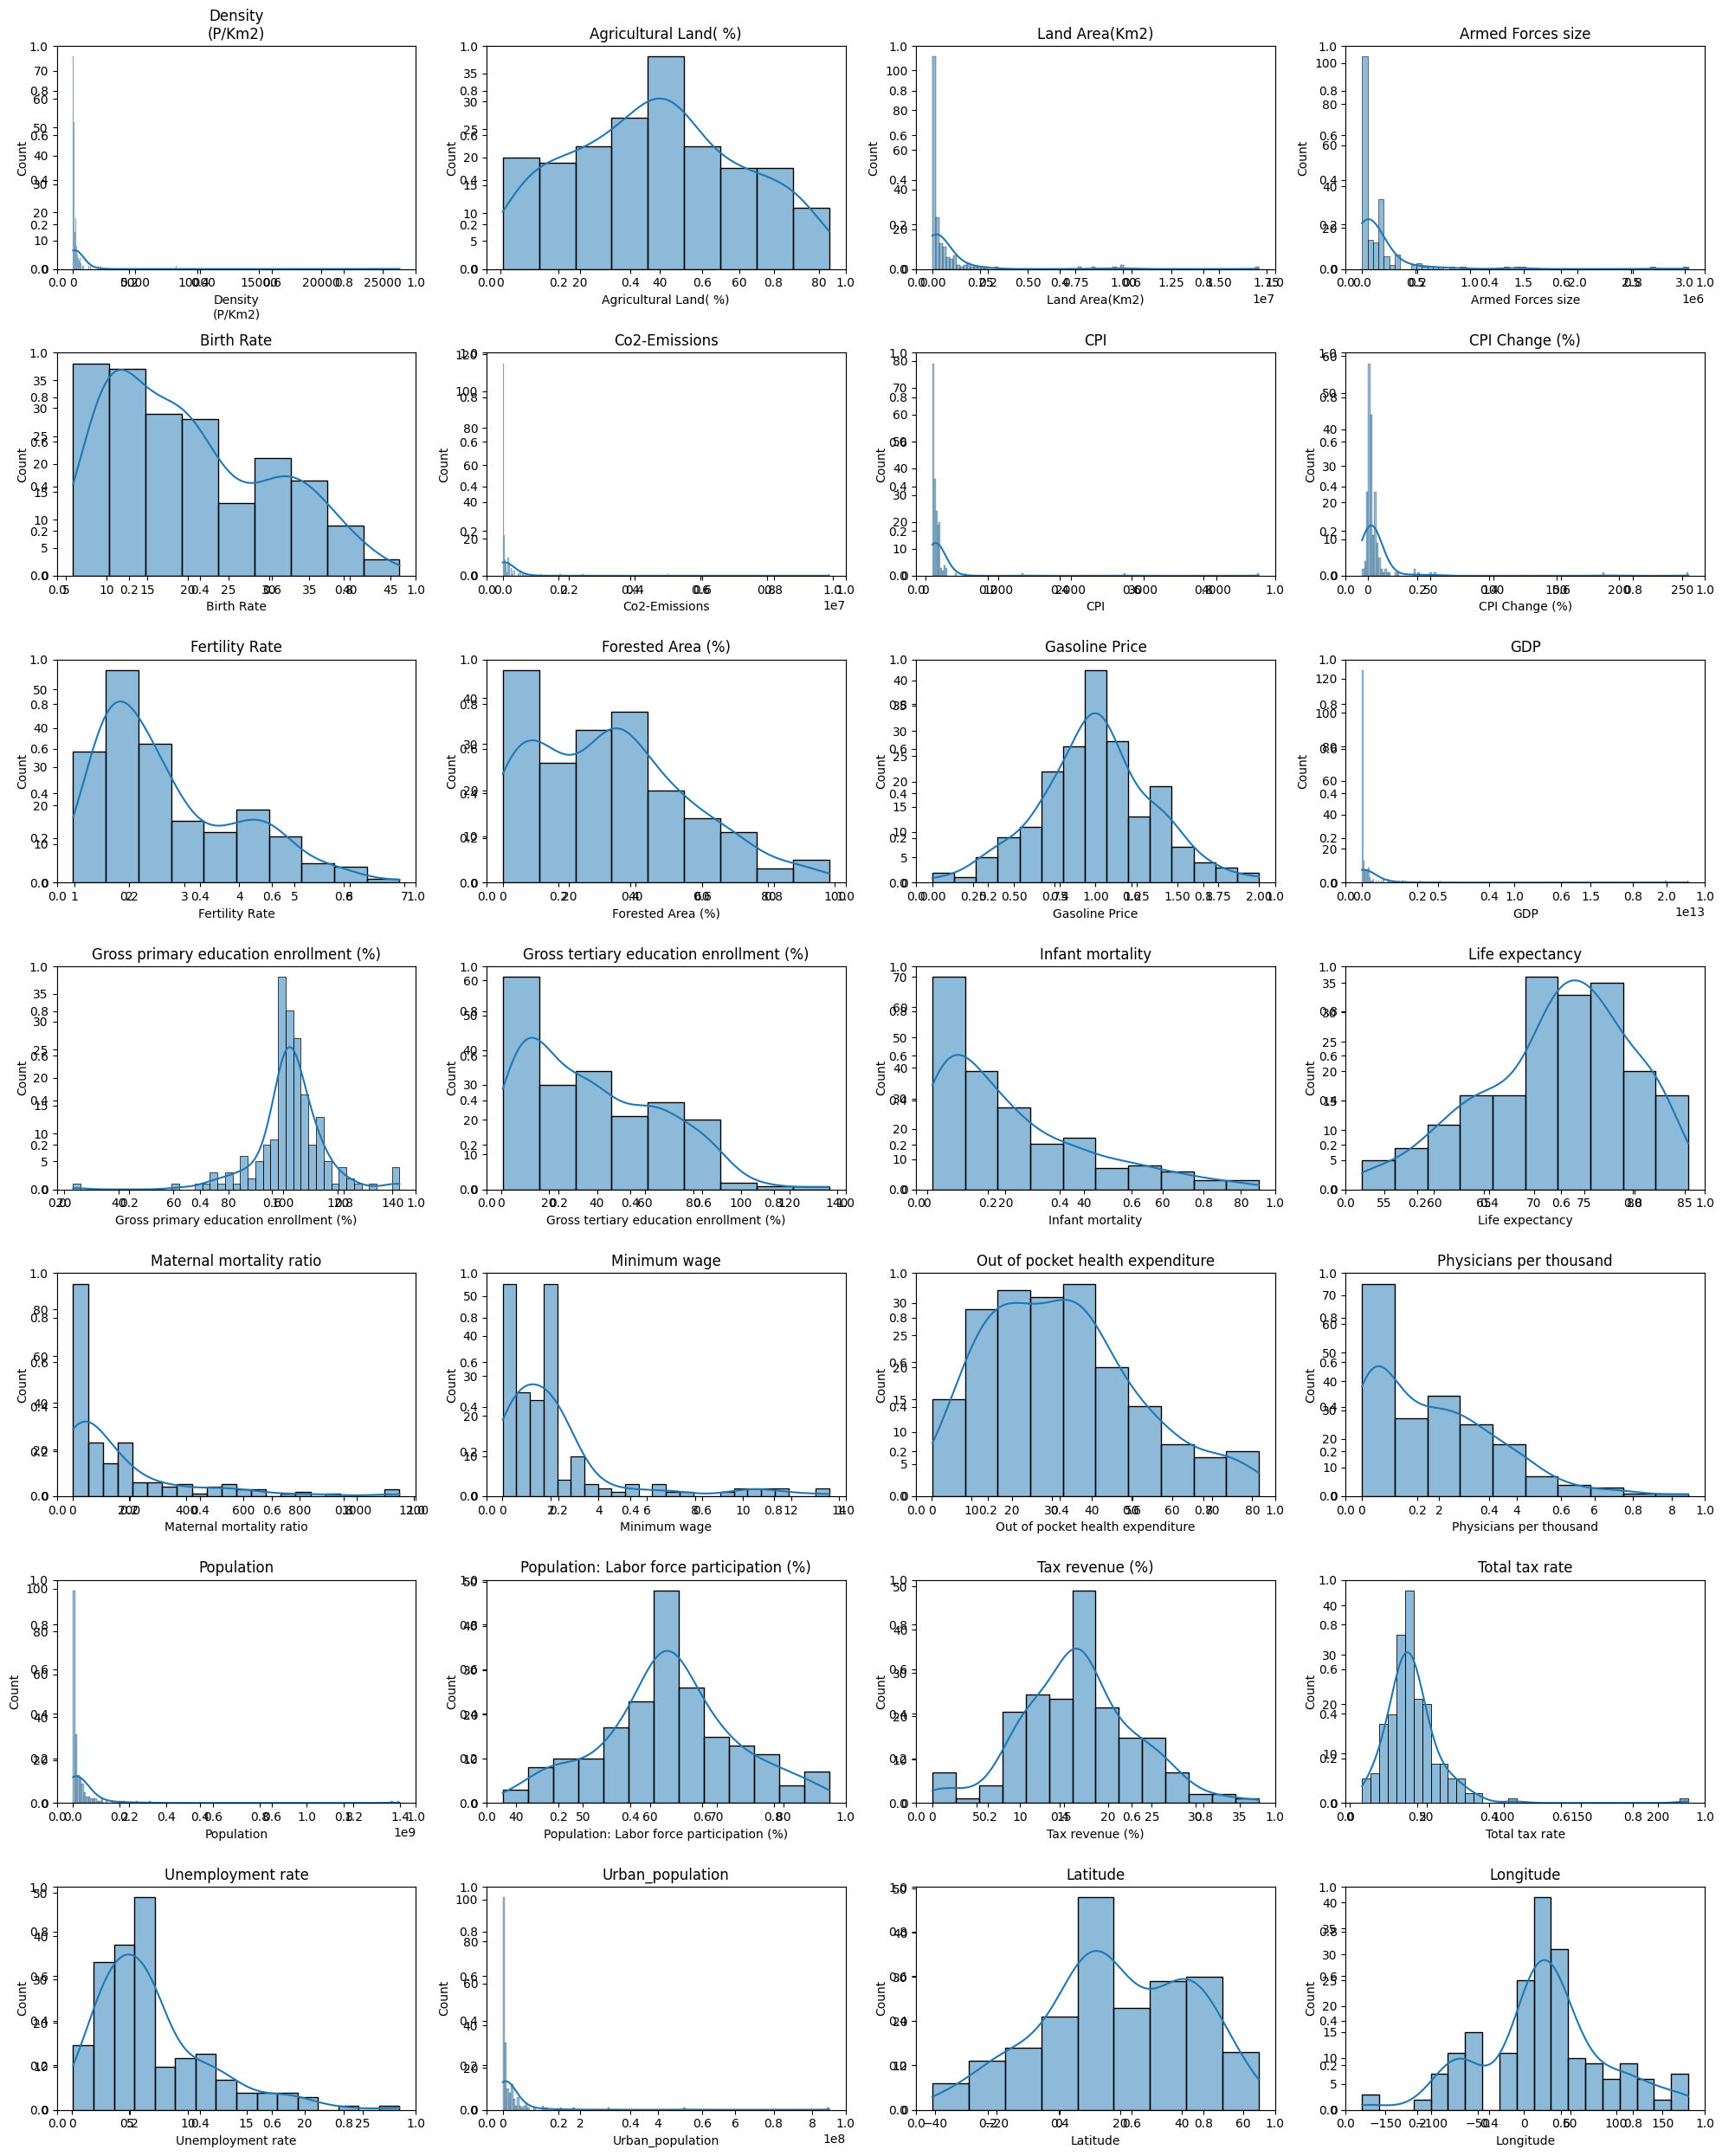

In [7]:
# Outlier Detection using Box Plots and Z-scores
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 25))
for i, col in enumerate(numeric_cols, start=1):
    ax = fig.add_subplot(7, 4, i)
    sns.boxplot(data=data_cleaned[col], ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Calculate Z-scores
z_scores = np.abs(stats.zscore(data_cleaned[numeric_cols]))

# Identify outliers (Z-score > 3)
outliers = np.where(z_scores > 3)

# Distribution Analysis using histograms and transformations
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 25))
for i, col in enumerate(numeric_cols, start=1):
    ax = fig.add_subplot(7, 4, i)
    sns.histplot(data_cleaned[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical columns for normalization (excluding 'Country')
numerical_cols_to_normalize = data_cleaned.select_dtypes(include=[np.number]).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalizing the data
data_cleaned[numerical_cols_to_normalize] = scaler.fit_transform(data_cleaned[numerical_cols_to_normalize])

# Verifying the normalization
normalized_summary_stats = data_cleaned[numerical_cols_to_normalize].describe()

# Displaying the normalized summary statistics
normalized_summary_stats

,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
count,195.000000,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,...,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,0.000000,-9.109522e-17,4.327023e-17,2.732857e-17,-9.109522e-17,6.376666e-17,-1.002047e-16,2.732857e-17,1.024821e-16,3.473005e-17,...,1.366428e-16,-4.554761e-17,-9.109522e-18,-4.327023e-16,6.205862e-17,-1.913000e-16,9.564998e-17,2.732857e-17,-9.109522e-18,-3.643809e-17
std,1.002574,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,...,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00
min,-0.179373,-1.805662e+00,-3.607332e-01,-4.481655e-01,-1.465853e+00,-2.164443e-01,-2.411561e-01,-4.718404e-01,-1.368283e+00,-1.374159e+00,...,-1.727655e+00,-1.109431e+00,-2.728182e-01,-2.486306e+00,-2.564945e+00,-1.652640e+00,-1.412467e+00,-3.002800e-01,-2.516631e+00,-2.944426e+00
25%,-0.162435,-7.719814e-01,-3.479404e-01,-4.129932e-01,-8.975330e-01,-2.132613e-01,-2.004319e-01,-2.428196e-01,-7.869291e-01,-8.827048e-01,...,-7.955793e-01,-8.972263e-01,-2.589377e-01,-5.515797e-01,-6.227386e-01,-4.996027e-01,-6.850727e-01,-2.839513e-01,-6.099054e-01,-4.202150e-01
50%,-0.135385,3.865019e-03,-2.976814e-01,-3.299864e-01,-2.012132e-01,-1.962606e-01,-1.600506e-01,-1.764678e-01,-3.409588e-01,0.000000e+00,...,-2.861388e-02,-1.636041e-01,-2.113256e-01,-7.141328e-16,0.000000e+00,-1.471459e-01,-2.008363e-01,-2.368302e-01,-7.276144e-02,1.065205e-02
75%,-0.070919,7.375204e-01,-7.085567e-02,0.000000e+00,8.427544e-01,-1.083300e-01,-2.894992e-02,-3.948345e-02,6.903474e-01,6.624795e-01,...,5.918825e-01,6.276166e-01,-7.271291e-02,5.590034e-01,5.766318e-01,3.261533e-01,4.060180e-01,-7.625041e-02,8.815017e-01,4.190587e-01
max,13.135939,2.038411e+00,8.583127e+00,8.080423e+00,2.648578e+00,1.182760e+01,1.158753e+01,1.062389e+01,3.354223e+00,2.845052e+00,...,2.607830e+00,3.989546e+00,9.410236e+00,2.418351e+00,3.192033e+00,9.001626e+00,4.425388e+00,1.105062e+01,1.924221e+00,2.377961e+00


## Making the Overall Dataset

In [9]:
import pandas as pd
import requests
import wikipediaapi
from tqdm import tqdm
import json

In [10]:

# Function to fetch Wikipedia summary and detailed content for a given country
def fetch_wikipedia_data(country, wiki, session):
    page = wiki.page(country)

    data = {"country": country}
    
    if page.exists():
        data.update({
            "title": page.title,
            "summary": page.summary,
            "url": page.fullurl,
        })

        # Function to get text from all sections and subsections up to 1500 words
        def get_text_from_sections(sections, word_limit):
            text = []
            current_word_count = 0

            for section in sections:
                if current_word_count >= word_limit:
                    break

                section_text = section.text.split()
                words_to_add = section_text[:100]

                text.extend(words_to_add)
                current_word_count += len(words_to_add)

                # Recursively add text from subsections if there are words remaining
                if section.sections and current_word_count < word_limit:
                    subsection_text = get_text_from_sections(section.sections, word_limit - current_word_count)
                    text.extend(subsection_text)
                    current_word_count += len(subsection_text)

            return text[:word_limit]

        total_words = 3000
        detailed_content = get_text_from_sections(page.sections, total_words)
        data["detailed_content"] = " ".join(detailed_content)
        
        # Fetch the last edited timestamp using MediaWiki API
        revisions_url = f"https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=timestamp&titles={country}&format=json"
        revisions_response = session.get(revisions_url)
        
        if revisions_response.status_code == 200:
            revisions_data = revisions_response.json()
            page_id = next(iter(revisions_data['query']['pages']))
            if 'revisions' in revisions_data['query']['pages'][page_id]:
                last_edited = revisions_data['query']['pages'][page_id]['revisions'][0]['timestamp']
                data["last_edited"] = last_edited
            else:
                data["last_edited"] = ''
        else:
            data["last_edited"] = ''
            print(f"Failed to fetch last edited timestamp for {country}: {revisions_response.status_code}")

    else:
        print(f"Page does not exist for {country}")

    # Ensure all keys exist in the returned dictionary
    for key in ["title", "summary", "url", "last_edited", "detailed_content"]:
        data.setdefault(key, "")

    return data

# Read the CSV file with country information
# csv_file_path = '/mnt/data/world-data-2023.csv'  # Replace with your CSV file path
df = data_cleaned

# Initialize lists to store the Wikipedia data
titles = []
summaries = []
urls = []
last_edited = []
detailed_contents = []

# Initialize Wikipedia API and requests session
wiki = wikipediaapi.Wikipedia('globe_proj (samir.c.asghar@gmail.com)', 'en')
session = requests.Session()

# Fetch Wikipedia summaries for each country
for country in tqdm(df['Country']):  # Assuming the CSV has a column named 'Country'
    wiki_data = fetch_wikipedia_data(country, wiki, session)
    titles.append(wiki_data['title'])
    summaries.append(wiki_data['summary'])
    urls.append(wiki_data['url'])
    last_edited.append(wiki_data['last_edited'])
    detailed_contents.append(wiki_data.get('detailed_content', ''))

# Add the Wikipedia data to the DataFrame
df['wiki_title'] = titles
df['wiki_summary'] = summaries
df['wiki_url'] = urls
df['wiki_last_edited'] = last_edited
df['wiki_detailed_content'] = detailed_contents

# Save the combined data as a JSON file
json_file_path = './countries_with_wikipedia_sections_data_processed_1.json'  # Replace with your desired JSON file path
df.to_json(json_file_path, orient='records', indent=4)

print("Data fetching and saving completed successfully.")

 77%|███████▋  | 151/195 [02:08<00:26,  1.66it/s]

Page does not exist for S�����������


100%|██████████| 195/195 [02:45<00:00,  1.18it/s]

Data fetching and saving completed successfully.


In [12]:
import weaviate
import os
import json
from dotenv import load_dotenv
import dateutil.parser

In [13]:
# Load environment variables from .env file
load_dotenv()

# Retrieve environment variables
cluster_url = os.getenv("WEAVIATE_CLUSTER_URL")
auth_api_key = os.getenv("WEAVIATE_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize Weaviate client
client = weaviate.Client(
    url=cluster_url,  # Replace with your Weaviate endpoint
    auth_client_secret=weaviate.AuthApiKey(api_key=auth_api_key),  # Replace with your Weaviate instance API key
    additional_headers={
        "X-OpenAI-Api-Key": openai_api_key  # Replace with your inference API key
    }
)

# Define the schema for the "DetailedCountry22" class if it doesn't already exist
class_obj = {
    "class": "DetailedCountry24",
    "vectorizer": "text2vec-openai",
    "moduleConfig": {
        "text2vec-openai": {},
        "generative-openai": {}
    },
    "properties": [
        {"name": "country", "dataType": ["string"]},
        {"name": "density", "dataType": ["string"]},
        {"name": "agricultural_land", "dataType": ["string"]},
        {"name": "land_area", "dataType": ["string"]},
        {"name": "armed_forces_size", "dataType": ["string"]},
        {"name": "birth_rate", "dataType": ["number"]},
        {"name": "co2_emissions", "dataType": ["string"]},
        {"name": "cpi", "dataType": ["number"]},
        {"name": "cpi_change", "dataType": ["string"]},
        {"name": "fertility_rate", "dataType": ["number"]},
        {"name": "forested_area", "dataType": ["string"]},
        {"name": "gasoline_price", "dataType": ["string"]},
        {"name": "gdp", "dataType": ["string"]},
        {"name": "gross_primary_education_enrollment", "dataType": ["string"]},
        {"name": "gross_tertiary_education_enrollment", "dataType": ["string"]},
        {"name": "infant_mortality", "dataType": ["number"]},
        {"name": "life_expectancy", "dataType": ["number"]},
        {"name": "maternal_mortality_ratio", "dataType": ["number"]},
        {"name": "minimum_wage", "dataType": ["string"]},
        {"name": "out_of_pocket_health_expenditure", "dataType": ["string"]},
        {"name": "physicians_per_thousand", "dataType": ["number"]},
        {"name": "population", "dataType": ["string"]},
        {"name": "labor_force_participation", "dataType": ["string"]},
        {"name": "tax_revenue", "dataType": ["string"]},
        {"name": "total_tax_rate", "dataType": ["string"]},
        {"name": "unemployment_rate", "dataType": ["string"]},
        {"name": "urban_population", "dataType": ["string"]},
        {"name": "latitude", "dataType": ["number"]},
        {"name": "longitude", "dataType": ["number"]},
        {"name": "wiki_title", "dataType": ["string"]},
        {"name": "wiki_summary", "dataType": ["string"]},
        {"name": "wiki_url", "dataType": ["string"]},
        {"name": "wiki_last_edited", "dataType": ["date"]},
        {"name": "wiki_detailed_content", "dataType": ["string"]}
    ]
}

# Add the class to the schema if it doesn't exist
if not client.schema.exists("DetailedCountry24"):
    client.schema.create_class(class_obj)

# Load JSON data from file
json_file_path = './countries_with_wikipedia_sections_data_processed_1.json'  # Replace with your JSON file path
with open(json_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)  # Load data from JSON file

# Configure batch
client.batch.configure(batch_size=1)

# Function to validate and insert data into Weaviate
def insert_country_data(country_data):
    # Validate and format the wiki_last_edited field
    wiki_last_edited = country_data.get("wiki_last_edited", "")
    if wiki_last_edited:
        try:
            # Check if the date is in RFC3339 format
            dateutil.parser.isoparse(wiki_last_edited)
        except ValueError:
            wiki_last_edited = None  # Set to None if not valid
    else:
        wiki_last_edited = None  # Set to None if empty

    # Convert fields to appropriate data types
    def parse_float(value, default=0.0):
        try:
            return float(value)
        except (TypeError, ValueError):
            return default

    birth_rate = parse_float(country_data.get("birth_rate"))
    cpi = parse_float(country_data.get("cpi"))
    fertility_rate = parse_float(country_data.get("fertility_rate"))
    infant_mortality = parse_float(country_data.get("infant_mortality"))
    life_expectancy = parse_float(country_data.get("life_expectancy"))
    maternal_mortality_ratio = parse_float(country_data.get("maternal_mortality_ratio"))
    physicians_per_thousand = parse_float(country_data.get("physicians_per_thousand"))
    latitude = parse_float(country_data.get("latitude"))
    longitude = parse_float(country_data.get("longitude"))

    properties = {
        "country": country_data.get("country", ""),
        "density": country_data.get("density", ""),
        "agricultural_land": country_data.get("agricultural_land", ""),
        "land_area": country_data.get("land_area", ""),
        "armed_forces_size": country_data.get("armed_forces_size", ""),
        "birth_rate": birth_rate,
        "co2_emissions": country_data.get("co2_emissions", ""),
        "cpi": cpi,
        "cpi_change": country_data.get("cpi_change", ""),
        "fertility_rate": fertility_rate,
        "forested_area": country_data.get("forested_area", ""),
        "gasoline_price": country_data.get("gasoline_price", ""),
        "gdp": country_data.get("gdp", ""),
        "gross_primary_education_enrollment": country_data.get("gross_primary_education_enrollment"),
        "gross_tertiary_education_enrollment": country_data.get("gross_tertiary_education_enrollment"),
        "infant_mortality": infant_mortality,
        "life_expectancy": life_expectancy,
        "maternal_mortality_ratio": maternal_mortality_ratio,
        "minimum_wage": country_data.get("minimum_wage", ""),
        "out_of_pocket_health_expenditure": country_data.get("out_of_pocket_health_expenditure", ""),
        "physicians_per_thousand": physicians_per_thousand,
        "population": country_data.get("population", ""),
        "labor_force_participation": country_data.get("labor_force_participation", ""),
        "tax_revenue": country_data.get("tax_revenue", ""),
        "total_tax_rate": country_data.get("total_tax_rate", ""),
        "unemployment_rate": country_data.get("unemployment_rate", ""),
        "urban_population": country_data.get("urban_population", ""),
        "latitude": latitude,
        "longitude": longitude,
        "wiki_title": country_data.get("wiki_title", ""),
        "wiki_summary": country_data.get("wiki_summary", ""),
        "wiki_url": country_data.get("wiki_url", ""),
        "wiki_last_edited": wiki_last_edited,
        "wiki_detailed_content": country_data.get("wiki_detailed_content", "")
    }

    client.data_object.create(properties, "DetailedCountry24")

# Batch import data
with client.batch as batch:
    for i, d in enumerate(data):
        print(f"Importing country: {i + 1}")
        insert_country_data(d)

print("Data import completed successfully.")

c:\Users\xamir\Documents\job_search_2023\bespoke_cvs\weavuate\globe_search_vector\globe_own\globeenv\Lib\site-packages\weaviate\__init__.py:130: DeprecationWarning: Dep010: Importing AuthApiKey from weaviate is deprecated. Import AuthApiKey from its module: weaviate.auth
  _Warnings.root_module_import(name, map_[name])
c:\Users\xamir\Documents\job_search_2023\bespoke_cvs\weavuate\globe_search_vector\globe_own\globeenv\Lib\site-packages\weaviate\warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


Importing country: 1
Importing country: 2
Importing country: 3
Importing country: 4
Importing country: 5
Importing country: 6
Importing country: 7
Importing country: 8
Importing country: 9
Importing country: 10
Importing country: 11
Importing country: 12
Importing country: 13
Importing country: 14
Importing country: 15
Importing country: 16
Importing country: 17
Importing country: 18
Importing country: 19
Importing country: 20
Importing country: 21
Importing country: 22
Importing country: 23
Importing country: 24
Importing country: 25
Importing country: 26
Importing country: 27
Importing country: 28
Importing country: 29
Importing country: 30
Importing country: 31
Importing country: 32
Importing country: 33
Importing country: 34
Importing country: 35
Importing country: 36
Importing country: 37
Importing country: 38
Importing country: 39
Importing country: 40
Importing country: 41
Importing country: 42
Importing country: 43
Importing country: 44
Importing country: 45
Importing country: 